# Hubble Catalog of Variables Notebook (API version)
### September 2019, Rick White & Steve Lubow

This notebook shows how to access the [Hubble Catalogs of Variables (HCV)](http://archive.stsci.edu/hlsp/hcv/).  The HCV is a large catalog of faint variable objects extracted from version 3 of the [Hubble Source Catalog](https://archive.stsci.edu/hst/hsc).  The HCV project at the National Observatory of Athens was funded by the European Space Agency (PI: Alceste Bonanos).  The data products for the HCV are available both at the [ESA Hubble Archive](http://archives.esac.esa.int/ehst) at [ESAC](https://www.cosmos.esa.int/web/esdc) through the [HCV Explorer](http://archives.esac.esa.int/hcv-explorer) interface and at STScI.

This notebook uses the [MAST HSC catalog interface](https://catalogs.mast.stsci.edu/hsc), which supports queries to the current and previous versions of the [Hubble Source Catalog](https://archive.stsci.edu/hst/hsc). It allows searches of several different tables including the HCV summary and detailed tables. It also has an associated [API](https://catalogs.mast.stsci.edu/docs/hsc.html) that is used for data access in this notebook.

For similar examples using the [MAST CasJobs](https://mastweb.stsci.edu/hcasjobs) interface,
a SQL database query interface that is more complex to use but more powerful than the API, see the [HCV_CasJobs_demo notebook](HCV_casjobs_demo.html).

This notebook is available for [download](HCV_API_demo.ipynb).

# Instructions: 
* Complete the initialization steps [described below](#initialization).
* Run the notebook to completion. 
* Modify and rerun any sections of the Table of Contents below.

Running the notebook from top to bottom takes less than 1 minute (depending on the speed of your computer and network connection).

# Table of Contents
* [Intialization](#initialization)
* [Variable objects in IC 1613](#ic1613)
    * [Name resolver](#resolver)
    * [Select objects from HCV](#summary)
    * [Information on HCV variable classification](#classification)
    * [Sky coverage](#positions)
    * [Properties of variable objects](#variability)
    * [Color magnitude diagram](#cmd)
* [Light curve for a nova in M87](#m87)
    * [Extract and plot light curve for the nova](#lightcurve)
    * [HLA cutout images for selected measurements](#cutouts)
* [Compare the HCV automatic classification to expert validations](#expert)
    * [Plot MAD variability index distribution](#mad_expert)
    * [Plot fraction of artifacts vs. MAD](#artifacts)
* [Plot light curve for most variable high-quality candidate in the HCV](#most_variable)

# Initialization <a name="initialization"></a>

### Install Python modules

_This notebook requires the use of **Python 3**._

This needs some special modules in addition to the common requirements of `astropy`, `numpy` and `scipy`.  For anaconda versions of Python the installation commands are:

<pre>
conda install requests
conda install pillow
</pre>

Run the commands one at a time since conda may ask for confirmation.

In [1]:
%matplotlib inline
import astropy, pylab, time, sys, os, requests, json
import numpy as np

from PIL import Image
from io import BytesIO

from astropy.table import Table, join
from astropy.io import ascii

# Set page width to fill browser for longer output lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

### Useful functions

* The `hcvcone(ra,dec,radius [,keywords])` function searches the HCV catalog near a position.
* The `hcvsearch()` function performs general non-positional queries.
* The `hcvmetadata()` function gives information about the columns available in a table. 
* The `resolve(name)` function uses the MAST Name Resolver (which relies on both SIMBAD and NED) to get the RA,Dec position for an object.

In [47]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"

def hcvcone(ra,dec,radius,table="hcvsummary",release="v3",format="csv",magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False,
            **kw):
    """Do a cone search of the HSC catalog (including the HCV)
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hcvsearch(table=table,release=release,format=format,magtype=magtype,
                     columns=columns,baseurl=baseurl,verbose=verbose,**data)


def hcvsearch(table="hcvsummary",release="v3",magtype="magaper2",format="csv",
              columns=None, baseurl=hscapiurl, verbose=False,
           **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{}.{}".format(cat2url(table,release,magtype,baseurl=baseurl),format)
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hcvmetadata(table,release,magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    print("REQUESTING:", url, data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def hcvmetadata(table="hcvsummary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = "{}/metadata".format(cat2url(table,release,magtype,baseurl=baseurl))
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def cat2url(table="hcvsummary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table,release,magtype)
    if table == "summary":
        url = "{baseurl}/{release}/{table}/{magtype}".format(**locals())
    else:
        url = "{baseurl}/{release}/{table}".format(**locals())
    return url


def checklegal(table,release,magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError("Bad value for release (must be one of {})".format(
            ', '.join(releaselist)))
    if release=="v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions",
                    "hcvsummary", "hcv")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(
            release, ", ".join(tablelist)))
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError("Bad value for magtype (must be one of {})".format(
                ", ".join(magtypelist)))


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position
    """

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)


def mastQuery(request, url='https://mast.stsci.edu/api/v0/invoke'):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    url (string): The service URL

    Returns the returned data content
    """
    
    # Encoding the request as a json string
    requestString = json.dumps(request)
    r = requests.post(url, data={'request': requestString})
    r.raise_for_status()
    return r.text

## Variable objects near IC 1613 <a name="ic1613"></a>

### Use MAST name resolver to get position of IC 1613 <a name="resolver"></a>

In [3]:
target = 'IC 1613'
ra, dec = resolve(target)
print(target,ra,dec)

IC 1613 16.19913 2.11778


### Select objects near IC 1613 from HCV <a name="summary"></a>

This searches the HCV summary table for objects within 0.5 degrees of the galaxy center.  Note that this returns both variable and non-variable objects.

In [58]:
radius = 0.5 # degrees
t0 = time.time()
tab = ascii.read(hcvcone(ra,dec,radius,table="hcv"))
print("Completed in {:.1f} sec".format(time.time()-t0))

# clean up the output format
# tab['MeanMag'].format = "{:.3f}"
# tab['MeanCorrMag'].format = "{:.3f}"
# tab['MAD'].format = "{:.4f}"
# tab['Chi2'].format = "{:.4f}"
# tab['RA'].format = "{:.6f}"
# tab['Dec'].format = "{:.6f}"

# show some of the variable sources
# tab[tab['AutoClass']>0]
tab

REQUESTING: https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/hcv.csv {'ra': 16.19913, 'dec': 2.11778, 'radius': 0.5}
Completed in 7.1 sec


<Table length=50000>
MatchID    Filter        MJD                ImageName             Mag        CorrMag         MagErr           CI                D        
 int64      str9       float64                str26             float64      float64        float64        float64           float64     
-------- --------- ---------------- -------------------------- --------- ---------------- ----------- ----------------- -----------------
26418045 ACS_F475W 53965.3322292117 hst_10505_07_acs_wfc_f475w   26.2395 26.2347629905456      0.1051 0.919166624546051  4.60332345962524
26418045 ACS_F475W 53965.4654353042 hst_10505_08_acs_wfc_f475w 26.231199 26.2303865053173      0.1039 0.923703730106354  4.92794322967529
26418045 ACS_F475W 53965.5986414445 hst_10505_09_acs_wfc_f475w   26.1411 26.1440524360187 0.096500002  1.01305556297302  2.49280428886414
26418045 ACS_F475W 53965.7318473519 hst_10505_10_acs_wfc_f475w   26.3181 26.3217956307786       0.111 0.871944427490234  6.84897041320801
26418045 ACS_F475W 53966.3312686377 hst_10505_11_acs_wfc_f475w   26.2204 26.2199286718763      0.1048 0.884907364845276  2.04357409477234
26418045 ACS_F475W 53966.4644747567 hst_10505_12_acs_wfc_f475w   26.2083 26.2097588398878      0.1031 0.948981463909149  3.80172371864319
26418045 ACS_F475W 53966.5976792511 hst_10505_13_acs_wfc_f475w   26.2637 26.2705612177264       0.107 0.856203734874725  4.20074081420898
26418045 ACS_F475W 53966.7308866074 hst_10505_14_acs_wfc_f475w   26.1882 26.1893568103512      0.1014 0.889999985694885   8.2232608795166
26418045 ACS_F475W  53967.263716463 hst_10505_15_acs_wfc_f475w   26.2953 26.3040704327497      0.1125 0.836296260356903  5.09105730056763
26418045 ACS_F475W 53967.3969227292 hst_10505_16_acs_wfc_f475w   26.2792 26.2766540398914      0.1086 0.896296262741089  3.50269317626953
     ...       ...              ...                        ...       ...              ...         ...               ...               ...
87480138 ACS_F475W 53965.7318473519 hst_10505_10_acs_wfc_f475w 26.287001 26.2925754760206      0.1147  1.14990735054016  4.80892324447632
87480138 ACS_F475W 53966.3312686377 hst_10505_11_acs_wfc_f475w 26.310101 26.3083077588827      0.1162  1.14750003814697  3.56336736679077
87480138 ACS_F475W 53966.4644747567 hst_10505_12_acs_wfc_f475w   26.2367 26.2366796757774      0.1095  1.14342594146729  6.68199586868286
87480138 ACS_F475W 53966.5976792511 hst_10505_13_acs_wfc_f475w 26.292101 26.2921827496829       0.115   1.0911111831665 0.739475429058075
87480138 ACS_F475W 53966.7308866074 hst_10505_14_acs_wfc_f475w   26.2892  26.292677291968      0.1133  1.14435184001923  5.80330371856689
87480138 ACS_F475W  53967.263716463 hst_10505_15_acs_wfc_f475w 26.274099 26.2793975290704      0.1143  1.08388888835907  1.31610107421875
87480138 ACS_F475W 53967.3969227292 hst_10505_16_acs_wfc_f475w   26.2544 26.2531094872087      0.1111  1.11509263515472  1.61812710762024
87480138 ACS_F475W 53967.5301286806 hst_10505_17_acs_wfc_f475w 26.186899 26.1833549977926      0.1048   1.2970370054245  14.7200441360474
87480138 ACS_F475W 53967.6633345857 hst_10505_18_acs_wfc_f475w 26.198601 26.1983417715976      0.1064   1.1812037229538  4.59722375869751
87480138 ACS_F814W 53965.3485949617 hst_10505_07_acs_wfc_f814w 26.007799 26.0091640438576      0.1041   1.0820369720459  4.89845132827759

### Description of the variable classification columns <a name="classification"></a>

Several of the table columns have information on the variability.

* The columns `AutoClass` and `ExpertClass` have summary information on the variability for a given `MatchID` object.
    * `AutoClass`: Classification as provided by the system: 0=constant 1=single filter variable candidate (SFVC) 2=multi-filter variable candidate (MFVC)
    * `ExpertClass`: Classification as provided by expert: 0=not classified by expert, 1=high confidence variable, 2=probable variable, 4=possible artifact
* The columns `MAD` and `Chi2` are variability indices using the median absolute deviation and the $\chi^2$ parameter for the given filter.
* The column `VarQualFlag` is a variability quality flag (see Section 5 of the paper). The five letters correspond to CI, D, MagerrAper2, MagAper2-MagAuto, p2p; AAAAA corresponds to the highest quality flag.
* The column `FilterDetFlag` is the filter detection flag: 1=source is variable in this filter, 0=source is not variable in this filter.

See the HCV paper by [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026) for more details on the computation and meaning of these quantities.

### Find objects with measurements in both F475W and F814W

This could be done in a SQL query through the CasJobs interface.  Here we use the `Astropy.table.join` function instead.

In [5]:
w475 = np.where(tab['Filter']=='ACS_F475W')
w814 = np.where(tab['Filter']=='ACS_F814W')

# the only key needed to do the join is MatchID, but we include other common columns
# so that join includes only one copy of them
jtab = join(tab[w475],tab[w814],
            keys=['MatchID','GroupID','SubGroupID','RA','Dec','AutoClass','ExpertClass'],
            table_names=['f475','f814'])
print(len(jtab),"matched F475W+F814W objects")
jtab[jtab['AutoClass']>0]

17090 matched F475W+F814W objects


<Table length=258>
 MatchID  Filter_f475 GroupID SubGroupID     RA      Dec    ... FilterDetFlag_f814 NumLC_f814 MeanMag_f814 MeanCorrMag_f814 MAD_f814 Chi2_f814
  int64      str11     int64    int64     float64  float64  ...       int64          int64      float64        float64      float64   float64 
--------- ----------- ------- ---------- --------- -------- ... ------------------ ---------- ------------ ---------------- -------- ---------
    96457   ACS_F475W   69810         -5 16.141516 2.177815 ...                  1         12       22.946           22.947   0.0402   77.5733
   813653   ACS_F475W   69810         -5 16.128353 2.160147 ...                  1         11       24.906           24.908   0.0795    8.5797
  1012692   ACS_F475W   69810         -5 16.134809 2.144720 ...                  1          8       25.208           25.210   0.1152    6.6471
  1085386   ACS_F475W   69810         -5 16.118544 2.160845 ...                  1         11       23.476           23.476   0.0697   40.7630
  1286857   ACS_F475W   69810         -5 16.119205 2.184252 ...                  0         12       21.073           21.075   0.0128   46.8982
  1309271   ACS_F475W   69810         -5 16.130571 2.152512 ...                  1         12       25.043           25.044   0.0804    5.2954
  1479646   ACS_F475W   69810         -5 16.120852 2.152737 ...                  1         12       22.501           22.503   0.0362   68.2414
  1661315   ACS_F475W   69810         -5 16.110571 2.143526 ...                  0         12       25.887           25.889   0.0595    0.8037
  1826474   ACS_F475W   69810         -5 16.101532 2.171855 ...                  1         11       24.889           24.890   0.0822    9.2131
  1849621   ACS_F475W   69810         -5 16.147049 2.153722 ...                  1         11       25.393           25.394   0.1483   18.3074
      ...         ...     ...        ...       ...      ... ...                ...        ...          ...              ...      ...       ...
102132800   ACS_F475W   69810         -5 16.126160 2.145442 ...                  1         12       24.503           24.505   0.1038   27.1660
102239423   ACS_F475W   69810         -5 16.138706 2.155652 ...                  0         12       22.735           22.737   0.0382   96.9001
103232694   ACS_F475W   69810         -5 16.107565 2.174399 ...                  1         11       22.425           22.426   0.0335   27.9930
104300195   ACS_F475W   69810         -5 16.124981 2.171772 ...                  1         12       25.382           25.384   0.1217    9.4811
105173757   ACS_F475W   69810         -5 16.133703 2.184506 ...                  1         12       22.240           22.242   0.1825  829.2399
106466795   ACS_F475W   69810         -5 16.127056 2.166390 ...                  0         12       25.257           25.259   0.0462    2.8032
106640363   ACS_F475W   69810         -5 16.135796 2.149099 ...                  0          9       24.944           24.946   0.0661    8.3312
106843213   ACS_F475W   69810         -5 16.110342 2.150373 ...                  1         12       24.429           24.431   0.0710   25.8158
107834538   ACS_F475W   69810         -5 16.107105 2.160084 ...                  0         12       25.128           25.129   0.0578    1.7916
108048053   ACS_F475W   69810         -5 16.150572 2.142590 ...                  0         11       24.544           24.546   0.0273    1.6361

### Plot object positions on the sky <a name="positions"></a>

We mark the galaxy center as well.  Note that this field is in the outskirts of IC 1613.  The 0.5 degree search radius (which is the maximum allowed in the API) allows finding these objects.

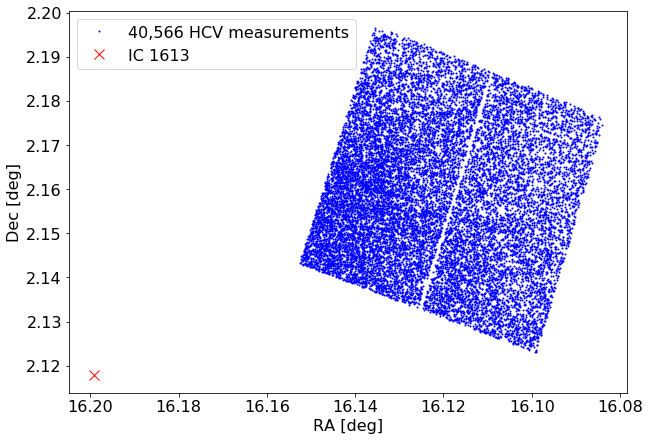

In [6]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.plot(jtab['RA'], jtab['Dec'], 'bo', markersize=1,
          label='{:,} HCV measurements'.format(len(tab)))
pylab.plot(ra,dec,'rx',label=target,markersize=10)
pylab.gca().invert_xaxis()
pylab.gca().set_aspect('equal')
pylab.xlabel('RA [deg]')
pylab.ylabel('Dec [deg]')
pylab.legend(loc='best')

### Plot HCV MAD variability index versus magnitude in F475W <a name="variability"></a>

The median absolute deviation variability index is used by the HCV to identify variables.  It measures the scatter among the multi-epoch measurements.  Some scatter is expected from noise (which increases for fainter objects).   Objects with MAD values that are high are likely to be variable.

This plots single-filter and multi-filter variable candidates (SFVC and MFVC) in different colors.  Note that variable objects with low F475W MAD values are variable in a different filter (typically F814W in this field).

This plot is similar to the upper panel of Figure 4 in [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026).

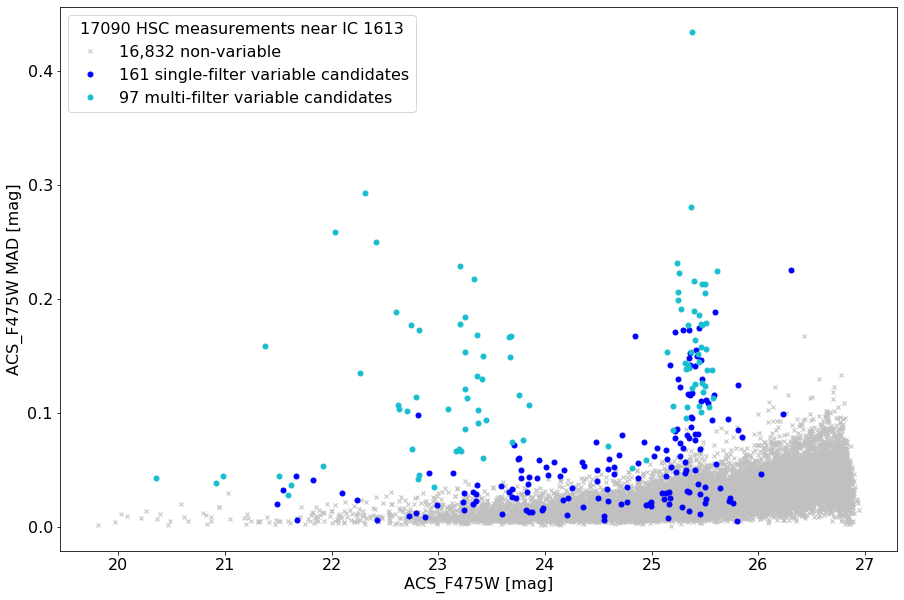

In [7]:
wnovar = np.where(jtab['AutoClass']==0)[0]
wsfvc = np.where(jtab['AutoClass']==1)[0]
wmfvc = np.where(jtab['AutoClass']==2)[0]
x = jtab['MeanCorrMag_f475']
y = jtab['MAD_f475']

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(15,10))
pylab.plot(x[wnovar], y[wnovar], 'x', markersize=4, color='silver',
          label='{:,} non-variable'.format(len(wnovar)))
pylab.plot(x[wsfvc], y[wsfvc], 'o', markersize=5, color='blue',
          label='{:,} single-filter variable candidates'.format(len(wsfvc)))
pylab.plot(x[wmfvc], y[wmfvc], 'o', markersize=5, color='tab:cyan',
          label='{:,} multi-filter variable candidates'.format(len(wmfvc)))

pylab.xlabel('ACS_F475W [mag]')
pylab.ylabel('ACS_F475W MAD [mag]')
pylab.legend(loc='best', title='{} HSC measurements near {}'.format(len(jtab),target))

### Plot variables in color-magnitude diagram <a name="cmd"></a>

Many of the candidate variables lie on the instability strip.

This plot is similar to the lower panel of Figure 4 in [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026).

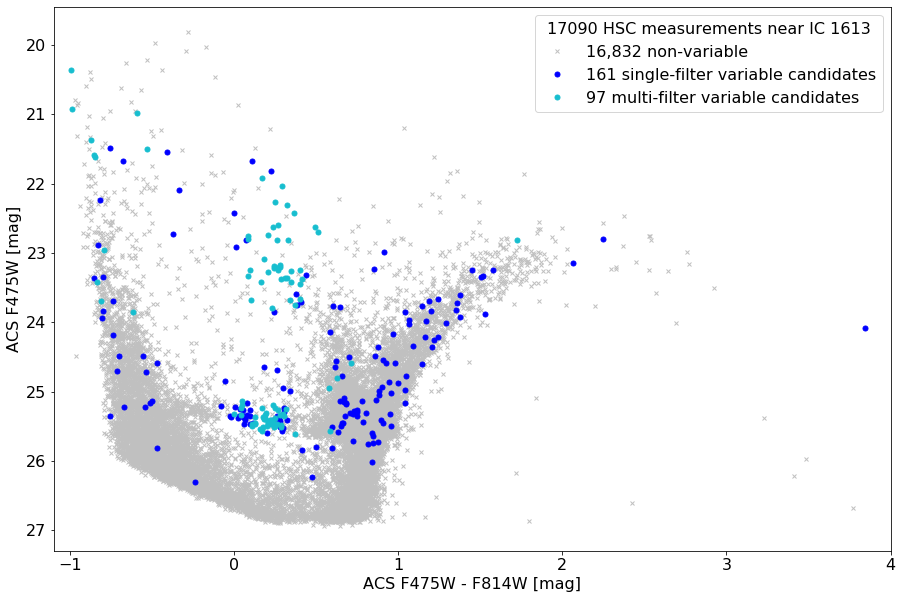

In [8]:
wnovar = np.where(jtab['AutoClass']==0)[0]
wsfvc = np.where(jtab['AutoClass']==1)[0]
wmfvc = np.where(jtab['AutoClass']==2)[0]
x = jtab['MeanCorrMag_f475'] - jtab['MeanCorrMag_f814']
y = jtab['MeanCorrMag_f475']

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(15,10))
pylab.plot(x[wnovar], y[wnovar], 'x', markersize=4, color='silver',
          label='{:,} non-variable'.format(len(wnovar)))
pylab.plot(x[wsfvc], y[wsfvc], 'o', markersize=5, color='blue',
          label='{:,} single-filter variable candidates'.format(len(wsfvc)))
pylab.plot(x[wmfvc], y[wmfvc], 'o', markersize=5, color='tab:cyan',
          label='{:,} multi-filter variable candidates'.format(len(wmfvc)))
pylab.gca().invert_yaxis()
pylab.xlim(-1.1, 4)
pylab.xlabel('ACS F475W - F814W [mag]')
pylab.ylabel('ACS F475W [mag]')
pylab.legend(loc='best', title='{} HSC measurements near {}'.format(len(jtab),target))

## Get a light curve for a nova in M87 <a name="m87"></a>

### Extract light curve for a given MatchID <a name="lightcurve"></a>

Note that the `MatchID` could be determined by positional searches, filtering the catalog, etc.  This object comes from the top left panel of Figure 9 in [Bonanos et al. (2019, AAp)](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201936026).

In [57]:
matchid = 1905457

t0 = time.time()

# get light curves for F606W and F814W
nova_606 = ascii.read(hcvsearch(table='hcv',MatchID=matchid))
print("{:.1f} sec: retrieved {} F606W measurements".format(time.time()-t0,len(nova_606)))

nova_814 = ascii.read(hcvsearch(table='hcv',MatchID=matchid,Filter='ACS_F814W'))
print("{:.1f} sec: retrieved {} F814W measurements".format(time.time()-t0,len(nova_814)))

# get the object RA and Dec as well
nova_tab = ascii.read(hcvsearch(table='hcvsummary',MatchID=matchid,Filter='ACS_F814W'))
print("{:.1f} sec: retrieved object info".format(time.time()-t0))

temp = nova_606.to_pandas()
temp

REQUESTING: https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/hcv.csv {'MatchID': 1905457}
0.4 sec: retrieved 43 F606W measurements
REQUESTING: https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/hcv.csv {'MatchID': 1905457, 'Filter': 'ACS_F814W'}
0.8 sec: retrieved 22 F814W measurements
REQUESTING: https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/hcvsummary.csv {'MatchID': 1905457, 'Filter': 'ACS_F814W'}
1.2 sec: retrieved object info


MatchID     Filter           MJD                   ImageName        Mag  \
0   1905457  ACS_F606W  53767.419795  hst_10543_29_acs_wfc_f606w  25.327000   
1   1905457  ACS_F606W  53768.419066  hst_10543_30_acs_wfc_f606w  23.969400   
2   1905457  ACS_F606W  53769.357654  hst_10543_31_acs_wfc_f606w  23.600500   
3   1905457  ACS_F606W  53771.101705  hst_10543_33_acs_wfc_f606w  23.610500   
4   1905457  ACS_F606W  53772.809853  hst_10543_35_acs_wfc_f606w  23.621799   
5   1905457  ACS_F606W  53774.474656  hst_10543_37_acs_wfc_f606w  24.015499   
6   1905457  ACS_F606W  53775.279911  hst_10543_38_acs_wfc_f606w  23.903700   
7   1905457  ACS_F606W  53776.089344  hst_10543_39_acs_wfc_f606w  24.015499   
8   1905457  ACS_F606W  53776.943985  hst_10543_40_acs_wfc_f606w  24.065701   
9   1905457  ACS_F606W  53778.562434  hst_10543_42_acs_wfc_f606w  24.430799   
10  1905457  ACS_F606W  53779.409726  hst_10543_43_acs_wfc_f606w  24.415899   
11  1905457  ACS_F606W  53780.209078  hst_10543_44_acs_wfc_f606w  24.697599   
12  1905457  ACS_F606W  53782.619159  hst_10543_47_acs_wfc_f606w  24.560801   
13  1905457  ACS_F606W  53784.217654  hst_10543_73_acs_wfc_f606w  24.782700   
14  1905457  ACS_F606W  53786.156323  hst_10543_86_acs_wfc_f606w  24.909100   
15  1905457  ACS_F606W  53787.022539  hst_10543_92_acs_wfc_f606w  25.114599   
16  1905457  ACS_F606W  53792.685096  hst_10543_49_acs_wfc_f606w  25.228001   
17  1905457  ACS_F606W  53793.526092  hst_10543_a1_acs_wfc_f606w  25.153601   
18  1905457  ACS_F606W  53796.148638  hst_10543_b8_acs_wfc_f606w  24.017200   
19  1905457  ACS_F606W  53798.589217  hst_10543_50_acs_wfc_f606w  25.563601   
20  1905457  ACS_F606W  53799.460894  hst_10543_c4_acs_wfc_f606w  25.589500   
21  1905457  ACS_F814W  53767.380982  hst_10543_29_acs_wfc_f814w  25.721500   
22  1905457  ACS_F814W  53768.380825  hst_10543_30_acs_wfc_f814w  24.409000   
23  1905457  ACS_F814W  53769.323105  hst_10543_31_acs_wfc_f814w  23.905500   
24  1905457  ACS_F814W  53771.061514  hst_10543_33_acs_wfc_f814w  23.716000   
25  1905457  ACS_F814W  53772.759066  hst_10543_35_acs_wfc_f814w  23.919201   
26  1905457  ACS_F814W  53773.617226  hst_10543_36_acs_wfc_f814w  24.145700   
27  1905457  ACS_F814W  53774.424286  hst_10543_37_acs_wfc_f814w  24.108299   
28  1905457  ACS_F814W  53775.245444  hst_10543_38_acs_wfc_f814w  24.063900   
29  1905457  ACS_F814W  53776.051207  hst_10543_39_acs_wfc_f814w  24.073999   
30  1905457  ACS_F814W  53776.888881  hst_10543_40_acs_wfc_f814w  24.075001   
31  1905457  ACS_F814W  53778.546277  hst_10543_42_acs_wfc_f814w  24.524799   
32  1905457  ACS_F814W  53779.376155  hst_10543_43_acs_wfc_f814w  24.650900   
33  1905457  ACS_F814W  53780.176033  hst_10543_44_acs_wfc_f814w  25.035101   
34  1905457  ACS_F814W  53782.583783  hst_10543_47_acs_wfc_f814w  24.833300   
35  1905457  ACS_F814W  53784.183030  hst_10543_73_acs_wfc_f814w  24.973801   
36  1905457  ACS_F814W  53786.140166  hst_10543_86_acs_wfc_f814w  25.339199   
37  1905457  ACS_F814W  53787.006381  hst_10543_92_acs_wfc_f814w  25.343399   
38  1905457  ACS_F814W  53792.668939  hst_10543_49_acs_wfc_f814w  25.704800   
39  1905457  ACS_F814W  53793.471275  hst_10543_a1_acs_wfc_f814w  25.433701   
40  1905457  ACS_F814W  53795.097654  hst_10543_a6_acs_wfc_f814w  25.433399   
41  1905457  ACS_F814W  53796.132481  hst_10543_b8_acs_wfc_f814w  25.705500   
42  1905457  ACS_F814W  53798.538234  hst_10543_50_acs_wfc_f814w  25.844101   

      CorrMag  MagErr        CI          D  
0   25.326713  0.1305  0.840648  13.499120  
1   23.967611  0.0394  1.043796  11.989554  
2   23.600084  0.0306  0.974167   9.304783  
3   23.615751  0.0303  0.966574   2.969337  
4   23.602994  0.0328  0.992037   4.454788  
5   24.012387  0.0426  1.024630   3.487479  
6   23.907755  0.0381  0.985185   3.497402  
7   24.018211  0.0414  1.053148   8.444670  
8   24.074389  0.0446  1.241574   7.674970  
9   24.427494  0.0595  1.074259   3.266622  
10  24.415058  0.0626  0.965278 

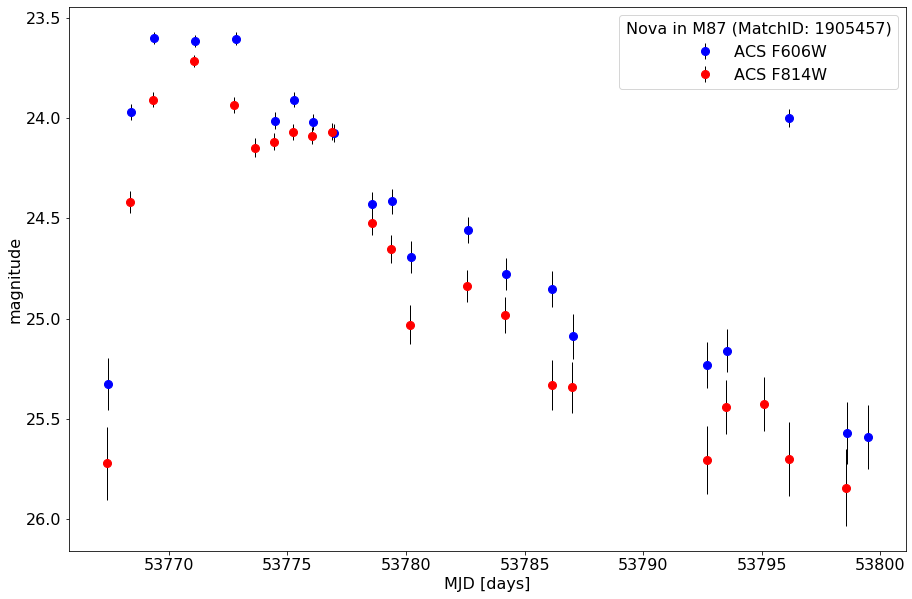

In [10]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(15,10))

x = nova_606['MJD']
y = nova_606['CorrMag']
e = nova_606['MagErr']
pylab.errorbar(x,y,yerr=e,fmt='ob',ecolor='k',elinewidth=1,markersize=8,label='ACS F606W')

x = nova_814['MJD']
y = nova_814['CorrMag']
e = nova_814['MagErr']
pylab.errorbar(x,y,yerr=e,fmt='or',ecolor='k',elinewidth=1,markersize=8,label='ACS F814W')

pylab.gca().invert_yaxis()
pylab.xlabel('MJD [days]')
pylab.ylabel('magnitude')
pylab.legend(loc='best', title='Nova in M87 (MatchID: {})'.format(matchid))

### Get HLA image cutouts for the nova <a name="cutouts"></a>

The [Hubble Legacy Archive (HLA)](https://hla.stsci.edu) images were the source of the measurements in the HSC and HCV, and it can be useful to look at the images.  Examination of the images can be useful to identified cosmic-ray contamination and other possible image artifacts.  In this case, no issues are seen, so the light curve is reliable.

Note that the ACS F606W images of M87 have only a single exposure, so they do have cosmic ray contamination.  The accompanying F814W images have multiple exposures, allowing CRs to be removed.  In this case the F814W combined image is used to find objects, while the F606W exposure is used only for photometry.  That reduces the effects of F606W CRs on the catalog but it is still a good idea to confirm the quality of the images.

The `get_hla_cutout` function reads a single cutout image (as a JPEG grayscale image) and returns a PIL image object.  See the documentation on the [fitscut image cutout service](http://hla.stsci.edu/fitscutcgi_interface.html) for more information on the web service being used.

[[0.7710831  0.7707993  0.7507419  ... 0.81518096 0.8263816  0.8159344 ]
 [0.76403314 0.77128893 0.77373916 ... 0.763977   0.8189588  0.86732084]
 [0.8088392  0.7749278  0.79789    ... 0.76324886 0.74928    0.8672762 ]
 ...
 [0.7409212  0.722212   0.70101184 ... 0.91069555 0.76692283 0.7547591 ]
 [0.74412596 0.7404764  0.69959843 ... 0.8634948  0.8471815  0.7891945 ]
 [0.7180665  0.7775746  0.7295904  ... 0.77540517 0.79284817 0.80243987]]
[[0.81614506 0.79836404 0.75376815 ... 0.8104737  0.8151644  0.80951864]
 [0.7998533  0.7847929  0.8013421  ... 0.8236342  0.82936317 0.77983963]
 [0.77404034 0.7595     0.8194458  ... 0.8436379  0.81745344 0.8035117 ]
 ...
 [0.7185735  0.73068917 0.74061203 ... 0.79106385 0.7576436  0.77389824]
 [0.7052121  0.7228721  0.7220519  ... 0.8114365  0.8027382  0.777935  ]
 [0.7180226  0.7124461  0.71838224 ... 0.80478275 0.82634604 0.8020935 ]]
[[0.8266755  0.86953115 0.7784175  ... 0.8584298  0.826672   0.84112203]
 [0.8416514  0.8433319  0.82609755 ... 

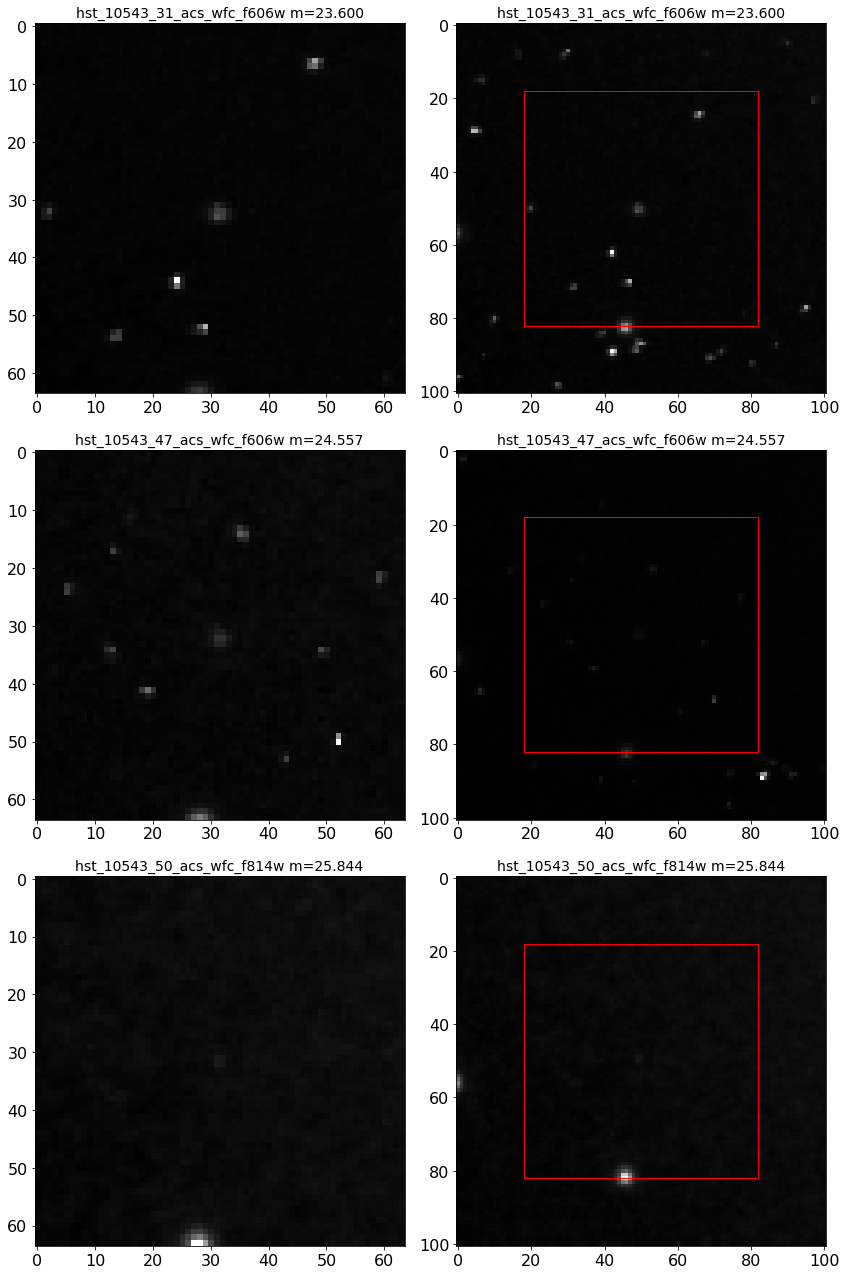

In [64]:
from astropy.io import fits

def get_hla_cutout(imagename,ra,dec,size=33,autoscale=99.5,asinh=True,zoom=1):
    
    """Get JPEG cutout for an image"""
    
    url = "https://hla.stsci.edu/cgi-bin/fitscut.cgi"
    r = requests.get(url, params=dict(ra=ra, dec=dec, size=size, 
            format="fits", red=imagename))
#     print(BytesIO(r.content))
    im = Image.open(BytesIO(r.content))
    im=fits.open(BytesIO(r.content))[0].data
    return im

# sort images by magnitude from brightest to faintest
phot = nova_606
isort = np.argsort(phot['CorrMag'])

# we plot zoomed-in and zoomed-out views side-by-side for each selected image
nim = len(ind)*2
ncols = 2 # images per row
nrows = (nim+ncols-1)//ncols

imsize1 = 64
imsize2 = 101
mra = nova_tab['RA'][0]
mdec = nova_tab['Dec'][0]

pylab.rcParams.update({"font.size":16})
pylab.figure(1,(12, (12/ncols)*nrows))
t0 = time.time()
ip = 0
for k in ind:
    im1 = get_hla_cutout(phot['ImageName'][k],mra,mdec,size=imsize1)
    ip += 1
    print(im1)
    pylab.subplot(nrows,ncols,ip)
    pylab.imshow(im1,origin="upper",cmap="gray")
    pylab.title('{} m={:.3f}'.format(phot['ImageName'][k],phot['CorrMag'][k]),fontsize=14)
    im2 = get_hla_cutout(phot['ImageName'][k],mra,mdec,size=imsize2)
    ip += 1
    pylab.subplot(nrows,ncols,ip)
    pylab.imshow(im2,origin="upper",cmap="gray")
    xbox = np.array([-1,1])*imsize1/2 + (imsize2-1)//2
    pylab.plot(xbox[[0,1,1,0,0]],xbox[[0,0,1,1,0]],'r-',linewidth=1)
    pylab.title('{} m={:.3f}'.format(phot['ImageName'][k],phot['CorrMag'][k]),fontsize=14)
pylab.tight_layout()
print("{:.1f} s: got {} cutouts".format(time.time()-t0,ip))

## Compare the HCV automatic classification to expert validations <a name="expert"></a>

The HCV includes an automatic classification `AutoClass` for candidate variables as well as an expert validation for some fields that were selected for visual examination.  For this example, we select all the objects in the HCV that have expert classification information.

In [12]:
t0 = time.time()

#get data for objects with an expert validation
constraints = {"ExpertClass.gte": 1}
tab = ascii.read(hcvsearch(table="hcvsummary",**constraints))
print("Retrieved {} rows in {:.1f} sec".format(len(tab),time.time()-t0))

# clean up the output format
tab['MeanMag'].format = "{:.3f}"
tab['MeanCorrMag'].format = "{:.3f}"
tab['MAD'].format = "{:.4f}"
tab['Chi2'].format = "{:.4f}"
tab['RA'].format = "{:.6f}"
tab['Dec'].format = "{:.6f}"

# tab includes 1 row for each filter (so multiple rows for objects with multiple filters)
# get an array that has only one row per object
mval, uindex = np.unique(tab['MatchID'],return_index=True)
utab = tab[uindex]
print("{} unique MatchIDs in table".format(len(utab)))

tab

Retrieved 31258 rows in 9.7 sec
13533 unique MatchIDs in table


<Table length=31258>
 MatchID     Filter   GroupID SubGroupID     RA        Dec     AutoClass ... VarQualFlag FilterDetFlag NumLC MeanMag MeanCorrMag   MAD     Chi2  
  int64      str11     int64    int64     float64    float64     int64   ...     str5        int64     int64 float64   float64   float64 float64 
--------- ----------- ------- ---------- ---------- ---------- --------- ... ----------- ------------- ----- ------- ----------- ------- --------
      875   ACS_F435W 1040153         -5  64.149673 -24.110353         2 ...       AAAAA             0    13  24.166      24.166  0.0384   7.1169
      875   ACS_F606W 1040153         -5  64.149673 -24.110353         2 ...       AAAAC             0     9  22.836      22.835  0.0349  81.3676
      875   ACS_F814W 1040153         -5  64.149673 -24.110353         2 ...       AAAAA             0    23  22.156      22.156  0.0325 141.7171
      875  WFC3_F105W 1040153         -5  64.149673 -24.110353         2 ...       CAAAB             1    14  21.843      21.843  0.0503 223.4961
      875  WFC3_F125W 1040153         -5  64.149673 -24.110353         2 ...       CBCCA             1     6  21.813      21.814  0.0655 792.8662
      875  WFC3_F140W 1040153         -5  64.149673 -24.110353         2 ...       AAAAA             0     6  21.705      21.704  0.0205 127.6242
      875  WFC3_F160W 1040153         -5  64.149673 -24.110353         2 ...       BABAA             1    13  21.623      21.624  0.0322 112.8544
     2006 WFPC2_F555W  521507         -5 268.112152 -17.684282         2 ...       AAAAC             1     7  21.811      21.821  0.1545  85.2812
     2006 WFPC2_F814W  521507         -5 268.112152 -17.684282         2 ...       AAAAA             1     7  20.513      20.519  0.0988 105.2348
    15830   ACS_F475W 1037453         -5 340.407806 -64.413185         1 ...       AACAA             1    16  25.713      25.714  0.1582  20.3584
      ...         ...     ...        ...        ...        ...       ... ...         ...           ...   ...     ...         ...     ...      ...
104519587   ACS_F775W  439774          5   5.753808 -72.068123         2 ...       CAAAC             1     8  21.662      21.668  0.0635  42.7806
104519587   ACS_F814W  439774          5   5.753808 -72.068123         2 ...       CAAAB             1    10  21.593      21.597  0.0435 489.3034
107976106  WFC3_F125W 1079516         -5  48.483875 -67.203285         2 ...       AAAAA             0     7  22.786      22.781  0.0352  16.8399
107976106  WFC3_F140W 1079516         -5  48.483875 -67.203285         2 ...       AAAAA             1     7  22.761      22.761  0.0600  15.9086
107976106  WFC3_F160W 1079516         -5  48.483875 -67.203285         2 ...       AAAAA             1     7  22.714      22.715  0.0416  21.5266
107923796 WFPC2_F450W 1039945          3  83.977821 -69.339401         2 ...       AAAAB             1     5  20.464      20.456  0.1244 288.6085
107923796 WFPC2_F606W 1039945          3  83.977821 -69.339401         2 ...       AAAAA             1     5  20.365      20.361  0.0854 782.1690
107923796 WFPC2_F814W 1039945          3  83.977821 -69.339401         2 ...       AAAAB             1     5  20.376      20.370  0.0838 237.4704
107923036   ACS_F555W 1053852          0 210.848816  54.349983         2 ...       AAAAA             1    15  25.203      25.200  0.2750  11.9710
107923036   ACS_F814W 1053852          0 210.848816  54.349983         2 ...       AAAAA             1    13  24.371      24.372  0.1776  19.3193

An `ExpertClass` value of 1 indicates that the object is confidently confirmed to be a variable; 2 means that the measurements do not have apparent problems and so the object is likely to be variable (usually the variability is too small to be obvious in the image); 4 means that the variability is likely to be the result of artifacts in the image (e.g., residual cosmic rays or diffraction spikes from nearby bright stars).

Compare the distributions for single-filter variable candidates (SFVC, `AutoClass`=1) and multi-filter variable candidates (MFVC, `AutoClass`=2).  The fraction of artifacts is lower in the MFVC sample.

In [13]:
sfcount = np.bincount(utab['ExpertClass'][utab['AutoClass']==1])
mfcount = np.bincount(utab['ExpertClass'][utab['AutoClass']==2])
sfrat = sfcount/sfcount.sum()
mfrat = mfcount/mfcount.sum()

print("Type Variable Likely Artifact Total")
print("SFVC {:8d} {:6d} {:8d} {:5d} counts".format(sfcount[1],sfcount[2],sfcount[4],sfcount.sum()))
print("MFVC {:8d} {:6d} {:8d} {:5d} counts".format(mfcount[1],mfcount[2],mfcount[4],mfcount.sum()))
print("SFVC {:8.3f} {:6.3f} {:8.3f} {:5.3f} fraction".format(sfrat[1],sfrat[2],sfrat[4],sfrat.sum()))
print("MFVC {:8.3f} {:6.3f} {:8.3f} {:5.3f} fraction".format(mfrat[1],mfrat[2],mfrat[4],mfrat.sum()))

Type Variable Likely Artifact Total
SFVC     3323   3055     1761  8139 counts
MFVC     2101   2442      851  5394 counts
SFVC    0.408  0.375    0.216 1.000 fraction
MFVC    0.390  0.453    0.158 1.000 fraction


### Plot the MAD variability index distribution with expert classifications <a name="mad_expert"></a>

Note that only the filters identified as variable (`FilterDetFlag` > 0) are included here.

This version of the plot shows the distributions for the various `ExpertClass` values along with, for comparison, the distribution for all objects in gray (which is identical in each panel).  Most objects are classified as confident or likely variables.  Objects with lower MAD values (indicating a lower amplitude of variability) are less likely to be identified as confident variables because low-level variability is more difficult to confirm via visual examination.

Text(0.5, 0, 'MAD Variability Index [mag]')

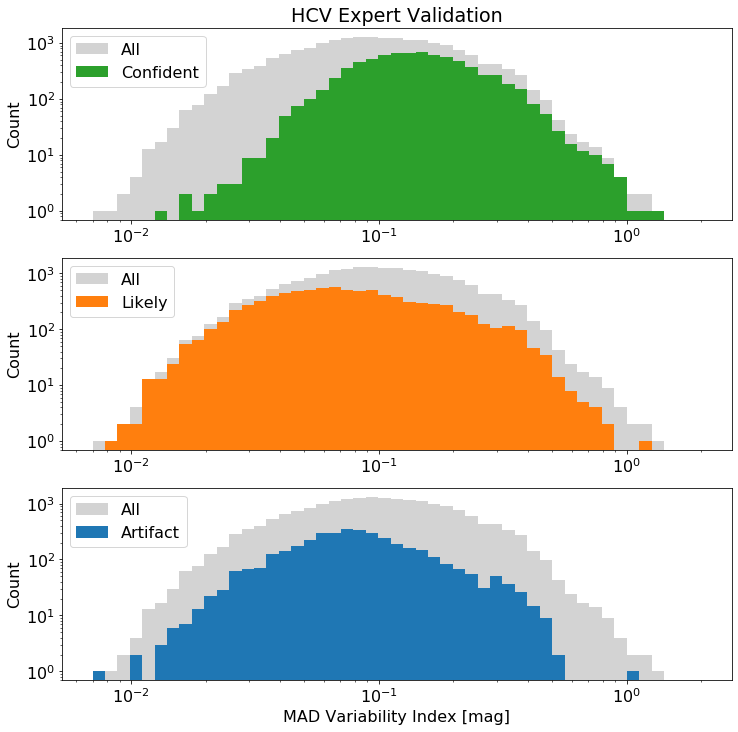

In [14]:
w = np.where(tab['FilterDetFlag']>0)[0]
mad = tab['MAD'][w]
e = tab['ExpertClass'][w]

xrange = [7.e-3, 2.0]
bins = xrange[0]*(xrange[1]/xrange[0])**np.linspace(0.0,1.0,50)

pylab.rcParams.update({'font.size':16})
pylab.figure(1,(12,12))

pylab.subplot(311)
pylab.hist(mad,bins=bins,log=True,color='lightgray',label='All')
wp = np.where(e==1)[0]
pylab.hist(mad[wp],bins=bins,log=True,label='Confident',color='C2')
pylab.xscale('log')
pylab.ylabel('Count')
pylab.legend(loc='upper left')
pylab.title('HCV Expert Validation')

pylab.subplot(312)
pylab.hist(mad,bins=bins,log=True,color='lightgray',label='All')
wp = np.where(e==2)[0]
pylab.hist(mad[wp],bins=bins,log=True,label='Likely',color='C1')
pylab.xscale('log')
pylab.ylabel('Count')
pylab.legend(loc='upper left')

pylab.subplot(313)
pylab.hist(mad,bins=bins,log=True,color='lightgray',label='All')
wp = np.where(e==4)[0]
pylab.hist(mad[wp],bins=bins,log=True,label='Artifact',color='C0')
pylab.xscale('log')
pylab.ylabel('Count')
pylab.legend(loc='upper left')

pylab.xlabel('MAD Variability Index [mag]')

The plot below shows the same distributions, but plotted as stacked histograms.  The top panel uses a linear scale on the y-axis and the bottom panel uses a log y scale.

In [ ]:
w = np.where(tab['FilterDetFlag']>0)[0]
mad = tab['MAD'][w]
e = tab['ExpertClass'][w]

xrange = [7.e-3, 2.0]
bins = xrange[0]*(xrange[1]/xrange[0])**np.linspace(0.0,1.0,50)

pylab.rcParams.update({'font.size':16})
pylab.figure(1,(15,12))

pylab.subplot(211)
hlog = False
pylab.hist(mad,bins=bins,log=hlog,label='Artifact')

wp = np.where(e<4)[0]
pylab.hist(mad[wp],bins=bins,log=hlog,label='Likely Variable')

wp = np.where(e==1)[0]
pylab.hist(mad[wp],bins=bins,log=hlog,label='Confident Variable')
pylab.xscale('log')
pylab.xlabel('MAD Variability Index [mag]')
pylab.ylabel('Count')
pylab.legend(loc='upper right',title='HCV Expert Validation')

pylab.subplot(212)
hlog = True
pylab.hist(mad,bins=bins,log=hlog,label='Artifact')

wp = np.where(e<4)[0]
pylab.hist(mad[wp],bins=bins,log=hlog,label='Likely Variable')

wp = np.where(e==1)[0]
pylab.hist(mad[wp],bins=bins,log=hlog,label='Confident Variable')
pylab.xscale('log')
pylab.xlabel('MAD Variability Index [mag]')
pylab.ylabel('Count')
pylab.legend(loc='upper right',title='HCV Expert Validation')

### Plot the fraction of artifacts as a function of MAD variability index <a name="artifacts"></a>

This shows how the fraction of artifacts varies with the MAD value.  For larger MAD values the fraction decreases sharply, presumably because such large values are less likely to result from the usual artifacts.  Interestingly, the artifact fraction also declines for smaller MAD values (MAD < 0.1 mag).  Probably that happens because typical artifacts are more likely to produce strong signals than the weaker signals indicated by a low MAD value. 

In [ ]:
w = np.where(tab['FilterDetFlag']>0)[0]
mad = tab['MAD'][w]
e = tab['ExpertClass'][w]

xrange = [7.e-3, 2.0]
bins = xrange[0]*(xrange[1]/xrange[0])**np.linspace(0.0,1.0,30)

all_count, bin_edges = np.histogram(mad,bins=bins)
artifact_count, bin_edges = np.histogram(mad[e==4],bins=bins)
wnz = np.where(all_count>0)[0]
nnz = len(wnz)

artifact_count = artifact_count[wnz]
all_count = all_count[wnz]
xerr = np.empty((2,nnz),dtype=float)
xerr[0] = bin_edges[wnz]
xerr[1] = bin_edges[wnz+1]

# combine bins at edge into one big bin to improve the statistics there
iz = np.where(all_count.cumsum()>10)[0][0]
if iz > 0:
    all_count[iz] += all_count[:iz].sum()
    artifact_count[iz] += artifact_count[:iz].sum()
    xerr[0,iz] = xerr[0,0]
    all_count = all_count[iz:]
    artifact_count = artifact_count[iz:]
    xerr = xerr[:,iz:]
iz = np.where(all_count[::-1].cumsum()>40)[0][0]
if iz > 0:
    all_count[-iz-1] += all_count[-iz:].sum()
    artifact_count[-iz-1] = artifact_count[-iz:].sum()
    xerr[1,-iz-1] = xerr[1,-1]
    all_count = all_count[:-iz]
    artifact_count = artifact_count[:-iz]
    xerr = xerr[:,:-iz]

x = np.sqrt(xerr[0]*xerr[1])
xerr[0] = x - xerr[0]
xerr[1] = xerr[1] - x

frac = artifact_count/all_count
# error on fraction using binomial distribution (approximate)
ferr = np.sqrt(frac*(1-frac)/all_count)

pylab.rcParams.update({'font.size':16})
pylab.figure(1,(12,12))

pylab.errorbar(x,frac,xerr=xerr,yerr=ferr,fmt='ob',
               markersize=5,label='Artifact fraction')

pylab.xscale('log')
pylab.xlabel('MAD Variability Index [mag]')
pylab.ylabel('Artifact Fraction')
pylab.legend(loc='upper right',title='HCV Expert Validation')

### Plot light curve for the most variable high quality candidate in the HCV <a name="most_variable"></a>

Select the candidate variable with the largest MAD value and `VarQualFlag` = 'AAAAA'.  To find the highest MAD value, we sort by MAD in descending order and select the first result.

In [ ]:
constraints = {'VarQualFlag': 'AAAAA', 'sort_by': 'MAD.desc', 'pagesize': 1}

t0 = time.time()
tab = ascii.read(hcvsearch(table='hcvsummary',**constraints))
print("Completed in {:.1f} sec".format(time.time()-t0))

# clean up the output format
tab['MeanMag'].format = "{:.3f}"
tab['MeanCorrMag'].format = "{:.3f}"
tab['MAD'].format = "{:.4f}"
tab['Chi2'].format = "{:.4f}"
tab['RA'].format = "{:.6f}"
tab['Dec'].format = "{:.6f}"

print("MatchID {} has largest MAD value = {:.2f}".format(
    tab['MatchID'][0],tab['MAD'][0]))
tab

Get and plot the light curve.

In [ ]:
matchid = tab['MatchID'][0]
mfilter = tab['Filter'][0]

t0 = time.time()
lc = ascii.read(hcvsearch(table="hcv",MatchID=matchid,Filter=mfilter))
print("{:.1f} sec: retrieved {} {} measurements".format(time.time()-t0,len(lc),mfilter))

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(15,10))

x = lc['MJD']
y = lc['CorrMag']
e = lc['MagErr']
pylab.errorbar(x,y,yerr=e,fmt='ob',ecolor='k',elinewidth=1,markersize=8,label=mfilter)

pylab.gca().invert_yaxis()
pylab.xlabel('MJD [days]')
pylab.ylabel('magnitude')
pylab.legend(loc='best', title='MatchID: {} MAD={:.2f}'.format(matchid, tab['MAD'][0]))

Extract cutout images for the entire light curve (since it does not have many points).

In [ ]:
# sort images in MJD order
ind = np.argsort(lc['MJD'])

# we plot zoomed-in and zoomed-out views side-by-side for each selected image
nim = len(ind)*2
ncols = 2 # images per row
nrows = (nim+ncols-1)//ncols

imsize1 = 19
imsize2 = 101
mra = tab['RA'][0]
mdec = tab['Dec'][0]

pylab.rcParams.update({"font.size":14})
pylab.figure(1,(12, (12/ncols)*nrows))
t0 = time.time()
ip = 0
for k in ind:
    im1 = get_hla_cutout(lc['ImageName'][k],mra,mdec,size=imsize1)
    ip += 1
    pylab.subplot(nrows,ncols,ip)
    pylab.imshow(im1,origin="upper",cmap="gray")
    pylab.title(lc['ImageName'][k],fontsize=14)
    im2 = get_hla_cutout(lc['ImageName'][k],mra,mdec,size=imsize2)
    ip += 1
    pylab.subplot(nrows,ncols,ip)
    pylab.imshow(im2,origin="upper",cmap="gray")
    xbox = np.array([-1,1])*imsize1/2 + (imsize2-1)//2
    pylab.plot(xbox[[0,1,1,0,0]],xbox[[0,0,1,1,0]],'r-',linewidth=1)
    pylab.title('m={:.3f} MJD={:.2f}'.format(lc['CorrMag'][k],lc['MJD'][k]),fontsize=14)
    print("{:.1f} s: finished {} of {} epochs".format(time.time()-t0,ip//2,len(ind)))
pylab.tight_layout()
print("{:.1f} s: got {} cutouts".format(time.time()-t0,ip))